## Huggett Model

- Author: Joao B. Duarte
- Last Update: 9/11/2020

In [3]:
# Import Libraries
import numpy as np
from numba import njit, jit
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from quantecon.markov import DiscreteDP
import matplotlib.pyplot as plt
from time import time
from matplotlib import rc
plt.style.use({'figure.facecolor':'white'})
rc('text', usetex=True)
%config InlineBackend.figure_format = 'retina'

Why market incompleteness?

- Complete markets assumption generates predictions in a broad set of models that are greatly inconsistent with the data
Carroll and Young (2009).

- Incomplete markets + idiosyncratic shocks: a way of producing robust and real world-like predictions for inequality.

### The incomplete-markets setting: the consumer

- Preferences: $E\sum_{t=0}^\infty β^t u(c_t)$.

- Consumption possibility set: budget $c_t + a_{t+1} = ε_t + (1+r_t) a_t$, borrowing constraint $a_{t+1} ≥ \phi$, and $c_t ≥ 0$.

- Asset markets: no insurance market but a riskless bond, priced at $r_t$.

- Shock process: labor income is $ε∈{ε_h,ε_l}$, with first-order Markov transitions: $\Pi = \begin{pmatrix} π_h & 1-π_h \\
 π_l & 1- π_l
\end{pmatrix}
$



####  Aggregate environment in which the consumer lives

- Other people: initially, at $t = 0$, a continuum of consumers with different asset holdings and different labor
income statuses. Joint distribution: the measure $Γ_0(a, ε)$.

- Aggregate shocks: none. Labor income shocks uncorrelated across agents. Law of large number holds. If $φ_t$ is the
fraction with $ε=ε_h$ at time $t$, we have $φ_{t+1}=φ_t π_h+(1−φ_t)π_l$.

- Market clearing for the asset: $\int_{\phi} a_{i,t+1} di = 0$ for all $t$, with a initial condition
$\int_{\phi} a_{i,0} di = 0$; $i$ denotes agent $i$.

- Aggregate resource constraint: an endowment economy, and thus $\int c_{i,t} di = \intε_{i,t}di$ for all $t$.

#### Stationary Equilibrium

Conceptually: an equilibrium, as defined above, such that $r_t$ and the distribution $Γ_t(a,ε)$ do not depend
on $t$. That is, the distribution of people over asset holdings and endowments looks the same every period,
but individuals move around within it. E.g., the number of people with $ε = ε_h$ and with $a < 2$ is the same
every period, even though each consumer only belongs to this group now and then.

Formally: we use recursive methods. The consumer problem is:

$$ V_s(a)= max_{a' ∈[\phi,(ε_s +a)(1+r)]} [u(ε_s+(1+r)a−a′)+β (π_s V_h(a′)+(1−π_s)V_l(a′))] $$ for all $s$ and $a$.

Decision rule: the problem delivers optimal asset holdings $a′ = g_s (a)$ satisfying, for all $s$ and $a$,

$$g_s (a) = argmax_{a′} [u(ε_s +(1+r)a−a′)+β(π_s V_h(a′) + (1 − π_s )V_l (a′)) ]$$

s.t. $a′ ∈ [\phi, (ε_s + a)(1+r)]$.

Asset-market clears, more precisely:

$$ \int_s \int_a g_s(a) \Gamma(a,s) = 0 $$


Assume a CRRA utility function and shock process: labor income is $y \in {y_h=5 ,y_l=2.5}$, with first-order Markov transitions:

\begin{align}
\Pi = \begin{pmatrix} 0.4 & 0.6 \\
                      0.6 & 0.4 \end{pmatrix}
\end{align}


### Solving using VFI in discrete grid

In [4]:
N = 100
agrid = np.linspace(-3,18, N)
beta = 1.03**(-1/12)
r = 0.00246
phi = -1
z = [0.5,1]
w = 5
PI = np.array([[0.4,0.6],[0.6,0.4]])
gamma=2


In [5]:
def u(c):
    util = np.empty(len(c))
    for i in range(len(c)):
        if c[i]>0:
             util[i]= c[i]**(1-gamma)/(1-gamma)
        else:
            util[i] = -np.infty
    return util


start = time()

v0 = np.zeros([N,2])

# We are now ready to go ahead using value function iteration.

metric = 1    # start the metric off at a distance of 1
its = 0       # initialise the iteration counter
tol = 10**-4

V = v0.copy()
v_1 = np.empty_like(v0)
aprime = agrid.copy()
g = np.empty((N,2))

# start iteration
while metric>tol:
    for j in range(0,2): # go over all possible epsilon states
        mu = z[j]
        for i in range(0,len(agrid)): # go over all possible a states
            a = agrid[i]
            aprime = np.amax((agrid,np.ones(N)*phi), axis=0) # borrowing constraint
            c = w*mu + (1+r)*a - aprime # evaluate c for all a': vector N by 1
            R = u(c) # evaluate instance utility for all a': vector N by 1
            v_1[i,j] = np.amax(R+beta*(PI[j,0]*V[:,0]+PI[j,1]*V[:,1]))
            g[i,j] = aprime[np.argmax(R+beta*(PI[j,0]*V[:,0]+PI[j,1]*V[:,1]))]
    metric = np.amax([abs(v_1-V)])
    V = v_1.copy()

    if its % 250 == 0:
        print(its, metric)
    its += 1  # keep track of iterations
print(its)

end = time()
print("Time of execution: "+str(end-start))

0 2.029962242702284
250 0.14426318223554802
500 0.07793073761047253
750 0.04209849809898003
1000 0.022741778271225144
1250 0.012285200239801952
1500 0.006636514661792603
1750 0.0035850719562233735
2000 0.0019366703136256547
2250 0.00104619710550935
2500 0.0005651598911242672
2750 0.00030530165001607656
3000 0.00016492518129496148
3205
Time of execution: 106.39657187461853


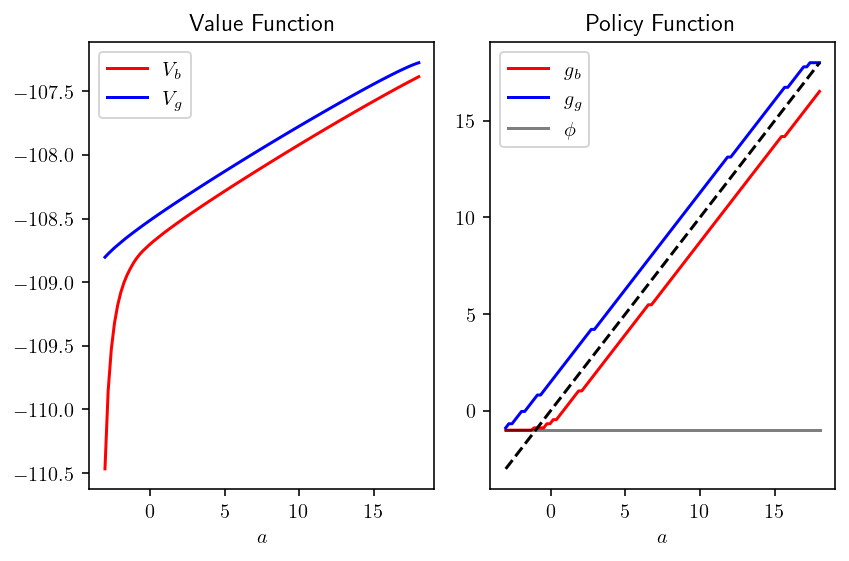

In [6]:
fig, ax = plt.subplots(1,2)

# Plot 1: Value Functions
ax[0].set_title("Value Function")
ax[0].plot(agrid, V[:,0], color = 'red', label =r'$V_b$')
ax[0].plot(agrid, V[:,1], color = 'blue', label =r'$V_g$')
ax[0].set_xlabel(r'$a$')
ax[0].legend()

# Plot 2: Policy Functions
ax[1].set_title("Policy Function")
ax[1].plot(agrid, g[:,0], color = 'red', label =r'$g_b$')
ax[1].plot(agrid, g[:,1], color = 'blue', label =r'$g_g$')
ax[1].plot(agrid, agrid, color = 'black', linestyle = '--')
ax[1].plot(agrid, np.ones(len(agrid))*phi, label = r'$\phi$', color = 'black', alpha = 0.5)
ax[1].set_xlabel(r'$a$')
ax[1].legend()
fig.tight_layout()
plt.show()

You will notice two issues with the previous approach:

1. Got high levels of current assets in the good state, agents would like to choose higher savings than its allowed
(we are fixed to choose in the discrete grid)

2. Its quite slow. And this can become quite time consuming when searching for the interest rate that clears the asset
market.

Lets speed it up with Python library called Numba!

Numba works by generating optimized machine code using the LLVM compiler infrastructure at import time, runtime, or statically (using the included pycc tool).

With a few annotations, array-oriented and math-heavy Python code can be just-in-time compiled to native machine instructions, similar in performance to C, C++ and Fortran, without having to switch languages or Python interpreters.

<div class="alert alert-danger" role="alert">
Caution: Everything must be written in Native Python or in Numpy objects!
</div>

In [8]:
z_values = np.array(z)
a_values = agrid.copy()
a1_values = agrid.copy()
parms = np.array([w, r, gamma, phi])
R = np.ones((2, N, N))*(-np.infty)
V = np.zeros([2,N])
v_1 = np.empty_like(V)
g = np.empty((2,N))

@jit
def T_numba(V, v_1,g, R, zgrid, agrid, a1_values):

    for i in range(0,len(zgrid)):
        mu = zgrid[i]
        for j in range(0,len(agrid)):
            a = agrid[j]
            for k in range(0,len(a1_values)):
                aprime = max(a1_values[k],phi)
                a1_values[k]=aprime
                c =   w*mu + (1+r)*a - aprime
                if c>0:
                    R[i,j,k] = c**(1-gamma)/(1-gamma)
                else:
                    R[i,j,k] = -np.infty
            v_1[i,j] = max(R[i,j,:]+beta*(PI[i,0]*V[0,:]+PI[i,1]*V[1,:]))
            g[i,j] = a1_values[np.argmax(R[i,j,:]+beta*(PI[i,0]*V[0,:]+PI[i,1]*V[1.:]))]
    return v_1, g

In [9]:
v1, g1= T_numba(V, v_1,g,  R, z_values, a_values, a1_values)

In [10]:
start = time()
v0 = np.zeros([N,2])
# We are now ready to go ahead using value function iteration.
metric = 1    # start the metric off at a distance of 1
its = 0       # initialise the iteration counter
tol = 10**-4

# start iteration
while metric>tol:
    v_1, g = T_numba(V, v1, g, R, z_values, a_values, a1_values)
    metric = np.amax([abs(v_1-V)])
    V = v_1.copy()

    if its % 250 == 0:
        print(its, metric)
    its += 1  # keep track of iterations
print(its)
gd = g.copy()
end = time()
print("Time of execution: "+str(end-start))

0 2.029962242702284
250 0.14426318223554802
500 0.07793073761047253
750 0.04209849809898003
1000 0.022741778271225144
1250 0.012285200239801952
1500 0.006636514661792603
1750 0.0035850719562233735
2000 0.0019366703136256547
2250 0.00104619710550935
2500 0.0005651598911242672
2750 0.00030530165001607656
3000 0.00016492518129496148
3205
Time of execution: 0.8839359283447266


A lot faster!

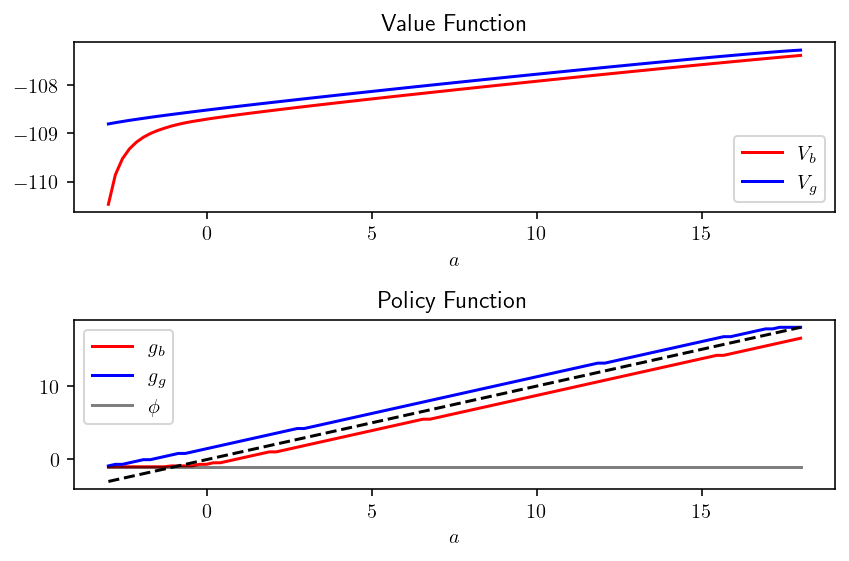

In [10]:
fig, ax = plt.subplots(2,1)

# Plot 1: Value Functions
ax[0].set_title("Value Function")
ax[0].plot(agrid, V[0,:], color = 'red', label =r'$V_b$')
ax[0].plot(agrid, V[1,:], color = 'blue', label =r'$V_g$')
ax[0].set_xlabel(r'$a$')
ax[0].legend()

# Plot 2: Policy Functions
ax[1].set_title("Policy Function")
ax[1].plot(agrid, g[0,:], color = 'red', label =r'$g_b$')
ax[1].plot(agrid, g[1,:], color = 'blue', label =r'$g_g$')
ax[1].plot(agrid, agrid, color = 'black', linestyle = '--')
ax[1].plot(agrid, np.ones(len(agrid))*phi, label = r'$\phi$', color = 'black', alpha = 0.5)
ax[1].set_xlabel(r'$a$')
ax[1].legend()
fig.tight_layout()
plt.show()

We can deal with fixed grid limitation with interpolation of V

In [31]:
N = 300
agrid = np.linspace(-3,18, N)
z_values = np.array(z)
a_values = agrid.copy()
a1_values = np.linspace(-3,22,N)
parms = np.array([w, r, gamma, phi])
R = np.ones((2, N, N))*(-np.infty)
V = np.zeros([2,N])
v_1 = np.empty_like(V)
g = np.empty((2,N))
Vb_int = interp1d(a_values,V[0,:],kind='linear', fill_value='extrapolate')
Vg_int = interp1d(a_values,V[1,:],kind='linear', fill_value='extrapolate')

Vb = Vb_int(a1_values)
Vg = Vg_int(a1_values)

@jit
def T2_numba(Vb,Vg, v_1,g, R, zgrid, agrid, a1_values):

    for i in range(0,len(zgrid)):
        mu = zgrid[i]
        for j in range(0,len(agrid)):
            a = agrid[j]
            for k in range(0,len(a1_values)):
                aprime = max(a1_values[k],phi)
                a1_values[k]=aprime
                c =   w*mu + (1+r)*a - aprime
                if c>0:
                    R[i,j,k] = c**(1-gamma)/(1-gamma)
                else:
                    R[i,j,k] = -np.infty
            v_1[i,j] = max(R[i,j,:]+beta*(PI[i,0]*Vb+PI[i,1]*Vg))
            g[i,j] = a1_values[np.argmax(R[i,j,:]+beta*(PI[i,0]*Vb+PI[i,1]*Vg))]
    return v_1, g

In [32]:
v1, g1= T2_numba(Vb, Vg, v_1,g,  R, z_values, a_values, a1_values)

In [33]:
start = time()
# We are now ready to go ahead using value function iteration.
metric = 1    # start the metric off at a distance of 1
its = 0       # initialise the iteration counter
tol = 10**-4

# start iteration
while metric>tol:
    v_1, g = T2_numba(Vb, Vg, v1, g, R, z_values, a_values, a1_values)
    metric = np.amax([abs(v_1-V)])
    V = v_1.copy()

    Vb_int = interp1d(a_values,V[0,:],kind='linear', fill_value='extrapolate')
    Vg_int = interp1d(a_values,V[1,:],kind='linear', fill_value='extrapolate')

    Vb = Vb_int(a1_values)
    Vg = Vg_int(a1_values)


    if its % 250 == 0:
        print(its, metric)
    its += 1  # keep track of iterations
print(its)

end = time()
print("Time of execution: "+str(end-start))

0 2.029962242702284
250 0.14406230815602328
500 0.07778167462392105
750 0.042017875762851986
1000 0.022698225575098263
1250 0.012261672897679432
1500 0.006623805096751312
1750 0.003578206197985878
2000 0.0019329614034404585
2250 0.0010441935373251
2500 0.0005640775555519895
2750 0.00030471696794620584
3000 0.00016460933370865405
3204
Time of execution: 5.138649940490723


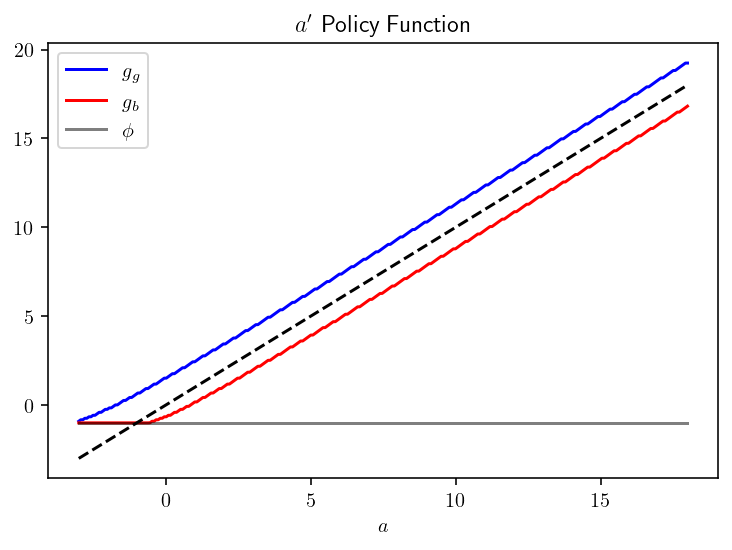

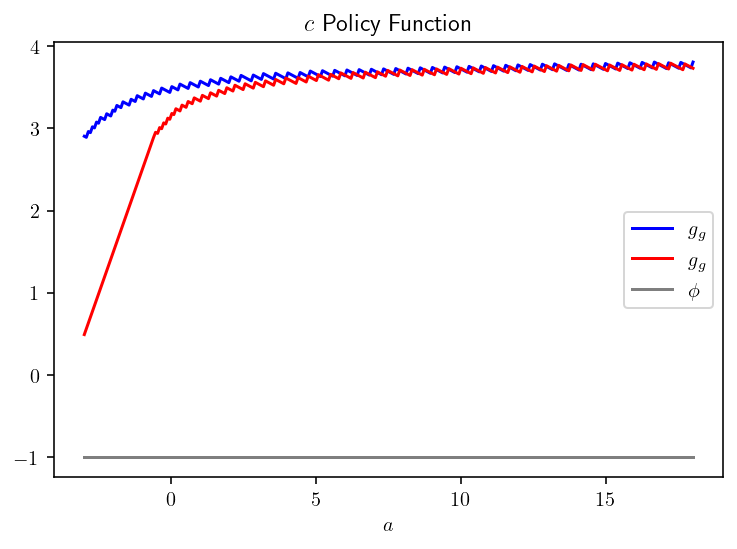

In [34]:
# Plot: Policy Functions
plt.title(r"$a'$ Policy Function")
plt.plot(agrid, g[1,:], color = 'blue', label =r'$g_g$')
plt.plot(agrid, g[0,:], color = 'red', label =r'$g_b$')
plt.plot(agrid, agrid, color = 'black', linestyle = '--')
plt.plot(agrid, np.ones(len(agrid))*phi, label = r'$\phi$', color = 'black', alpha = 0.5)
plt.xlabel(r'$a$')
plt.legend()
plt.show()

plt.title(r"$c$ Policy Function")
plt.plot(agrid, w*z_values[1] + (1 + r)*agrid - g[1,:], color = 'blue', label =r'$g_g$')
plt.plot(agrid, w*z_values[0] + (1 + r)*agrid - g[0,:], color = 'red', label =r'$g_g$')
plt.plot(agrid, np.ones(len(agrid))*phi, label = r'$\phi$', color = 'black', alpha = 0.5)
plt.xlabel(r'$a$')
plt.legend()
plt.show()


Now that we have solved the household problem and got $g(a,z)$, we can compute the stationary distribution of assets:

Recall the stationary distribution is:
$$ \Gamma(\hat{a},\hat{y}) = P(a\leq\hat{a},y=\hat{y}) $$.


Continuum of households makes the wealth distribution a continuous function and therefore an infinite-dimension object
in the state space. Need approximation!

If $g$ is monotonic, then the invariante distribution can be characterized as:

$$\Gamma(a',{y'}) = \sum \limits_{y\in \mathcal{Y}} \pi(y'|y) \Gamma(g^{-1}(a',y),{y})$$

There are several methods that approximate the stationary distribution:

1. Splines interpolation + inversion of $g$ + interation
    **Approach**: approximate $\Gamma$ with splines and iterate on the the law of motion above until convergence.

    1. We need a grid $A$ of interpolation nodes in the interval. This needs to be much more finer than for policy.

    2. Have an initial guess $\Gamma_0$. Uniform distribution is fine.

    3. Spline approximation of $g^{-1}$ and $\Gamma_0$

    4. Iterate

    In the Huggett model with a domain where binding borrowing constraints case, we cannot use this approach since $g$ is not strictly montotonic.

2. Discretization of invariant density function $\phi(a,y)$ + iteration

3. Turn $g$ into a transition matrix and compute the eigenvector associated with the unitary eigenvalue.
    $\phi(a,y) = M \phi(a,y)$, so $(M-I)\phi(a,y)=0$

4. Monte Carlo simulation until markov chain has converged to stationary distribution

In [11]:
gb = savgol_filter(gd[0,:], 51, 3)
gg = savgol_filter(gd[1,:], 51, 3)

gb = interp1d(agrid, gb, kind='linear', fill_value='extrapolate')
gg = interp1d(agrid, gg, kind='linear', fill_value='extrapolate')

a_vals = np.linspace(-3, 18, N)
a1b_star = gb(a_vals)
a1g_star = gg(a_vals)

# back to discrete g function
F = interp1d(a_vals,a_vals, kind = 'next', fill_value = 18.0, bounds_error=False)
a1gd_star = F(gg(a_vals))
a1bd_star = F(gb(a_vals))

Tg = np.zeros([N,N])
Tb = np.zeros([N,N])
ixg = np.where(a_vals==a1bd_star[20])
print(a_vals[10],a_vals[ixg], ixg)

-0.8787878787878789 [0.39393939] (array([16]),)


In [12]:
@njit
def populate_M(a_vals, N, a1gd_star, a1bd_star, a1g_star, a1b_star, Tb, Tg, PI):
    for i in range(N):
        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        Tg[i,ixg-1] = 1-Tg[i,ixg]

        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            Tb[i,ixb-1] = 1-Tb[i,ixb]
    P = PI
    M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)
    return M

[1.+0.j]


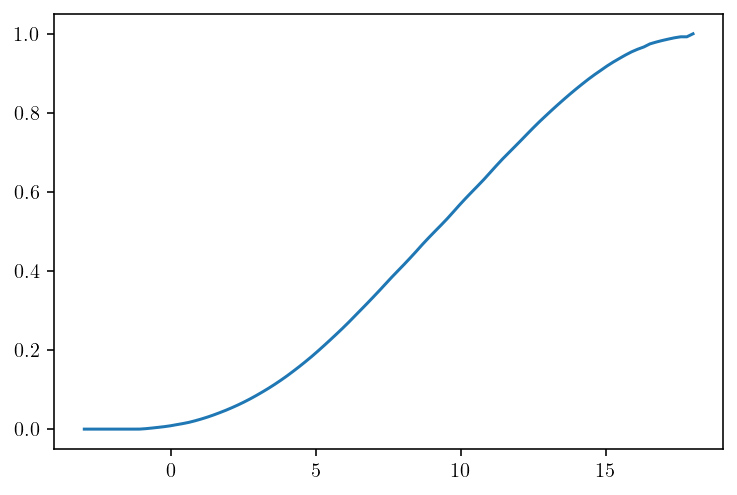

In [13]:
M = populate_M(a_vals, N, a1gd_star, a1bd_star, a1g_star, a1b_star, Tb, Tg, PI)
#print(M[100,:])
from scipy.sparse import csr_matrix
M = csr_matrix(M)

M2 = csr_matrix.transpose(M)
import scipy.sparse.linalg as sla

D, V = sla.eigs(M2, k=1, sigma = 1.0)
print(D)
V = np.real(V[:,0])/sum(np.real(V[:,0]))
V[V<0]=0
V = np.real(V)/sum(np.real(V))
#print(V[199])
dist = V[0:N]+V[N:]

plt.plot(a_vals, np.cumsum(dist))

Total net assets is: 9.135665301677864


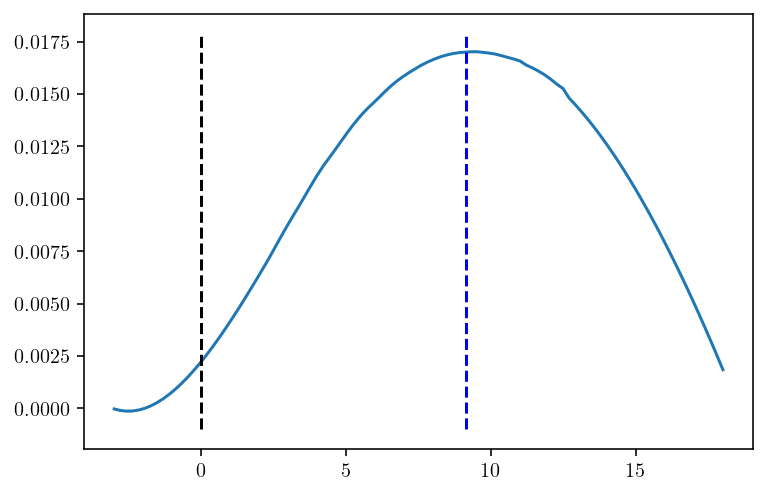

In [65]:
dist_c = savgol_filter(dist, 51, 3)
mean_a = np.dot(a_vals.T,dist)
print('Total net assets is:', mean_a)
plt.plot(a_vals[:], dist_c)
ylim = plt.gca().get_ylim()
plt.plot(np.zeros(30), np.linspace(ylim[0],ylim[1], 30),'k--')
plt.plot(np.ones(30)*mean_a, np.linspace(ylim[0],ylim[1], 30),'b--')
plt.show()

### Lets find the interest rate that clears the asset market

In [15]:
N = 100
agrid = np.linspace(-3,18, N)
beta = 1.03**(-1/12)
r = -0.2
phi = -1
z = [0.5,1]
w = 5
PI = np.array([[0.4,0.6],[0.6,0.4]])
gamma=2
parms = [N, agrid, beta, phi, z, w, PI, gamma]

def r_to_A(r, parms = parms):
    N = parms[0]
    agrid = parms[1]
    beta = parms[2]
    phi = parms[3]
    z = parms[4]
    w = parms[5]
    PI = parms[6]
    gamma=parms[7]

    z_values = np.array(z)
    a_values = agrid.copy()
    a1_values = agrid.copy()
    R = np.ones((2, N, N))*(-np.infty)
    V = np.zeros([2,N])
    v1 = np.empty_like(V)
    g = np.empty((2,N))

    metric = 1    # start the metric off at a distance of 1
    tol = 10**-4

    # start iteration
    while metric>tol:
        v_1, g = T_numba(V, v1, g, R, z_values, a_values, a1_values, r, beta, phi, w, gamma, PI)
        metric = np.amax([abs(v_1-V)])
        V = v_1.copy()

    gb = savgol_filter(g[0,:], 51, 3)
    gg = savgol_filter(g[1,:], 51, 3)

    gb = interp1d(agrid, gb, kind='linear', fill_value='extrapolate')
    gg = interp1d(agrid, gg, kind='linear', fill_value='extrapolate')

    N = 300
    a_vals = np.linspace(-3, 18, N)
    a1b_star = gb(a_vals)
    a1g_star = gg(a_vals)

    F = interp1d(a_vals,a_vals, kind = 'next', fill_value = 18.0, bounds_error=False)
    a1gd_star = F(gg(a_vals))
    a1bd_star = F(gb(a_vals))

    Tg = np.zeros([N,N])
    Tb = np.zeros([N,N])

    M = populate_M(a_vals, N, a1gd_star, a1bd_star, a1g_star, a1b_star, Tb, Tg, PI)

    from scipy.sparse import csr_matrix
    M = csr_matrix(M)

    M2 = csr_matrix.transpose(M)
    import scipy.sparse.linalg as sla

    D, V = sla.eigs(M2, k=1, sigma = 1.0)
    V = np.real(V)/sum(np.real(V))
    dist = V[0:N]+V[N:]
    mean_a = np.dot(a_vals.T,dist)

    return mean_a, dist

# Heavy lifting functions
@jit
def T_numba(V, v_1,g, R, zgrid, agrid, a1_values, r, beta, phi, w, gamma, PI):

    for i in range(0,len(zgrid)):
        mu = zgrid[i]
        for j in range(0,len(agrid)):
            a = agrid[j]
            for k in range(0,len(a1_values)):
                aprime = max(a1_values[k],phi)
                a1_values[k]=aprime
                c =   w*mu + (1+r)*a - aprime
                if c>0:
                    R[i,j,k] = c**(1-gamma)/(1-gamma)
                else:
                    R[i,j,k] = -np.infty
            v_1[i,j] = max(R[i,j,:]+beta*(PI[i,0]*V[0,:]+PI[i,1]*V[1,:]))
            g[i,j] = a1_values[np.argmax(R[i,j,:]+beta*(PI[i,0]*V[0,:]+PI[i,1]*V[1.:]))]
    return v_1, g

@njit
def populate_M(a_vals, N, a1gd_star, a1bd_star, a1g_star, a1b_star, Tb, Tg, PI):
    for i in range(N):
        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        if Tg[i,ixg] > 1:
            Tg[i,ixg] = 1.0
        Tg[i,ixg-1] = 1-Tg[i,ixg]

        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            Tb[i,ixb-1] = 1-Tb[i,ixb]
    P = PI
    M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)
    return M

In [16]:
# Lets plot net supply of A for different r
rs = np.linspace(-0.2,0.003, 20)
As = []
dists = []
for r in rs:
    As.append(r_to_A(r,parms)[0])
    dists.append(r_to_A(r,parms)[1])


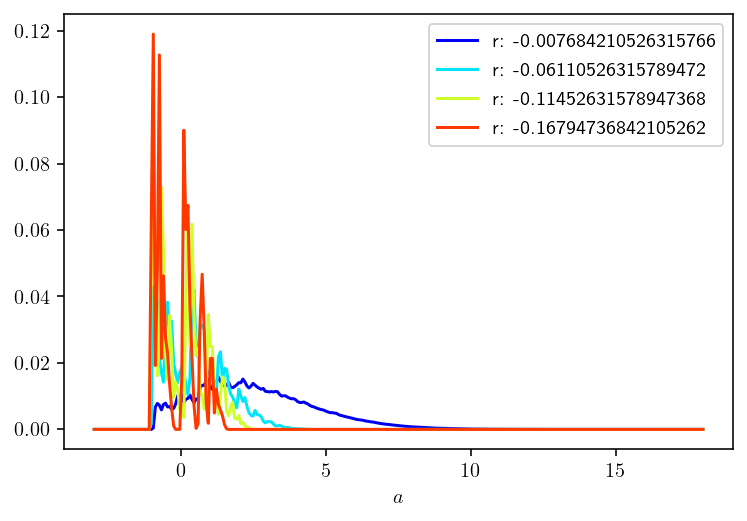

In [18]:
a_vals = np.linspace(-3, 18, 300)
for i in range(-2,-20, -5):
    plt.plot(a_vals, (dists[i].reshape(300)), color = plt.cm.jet(-i/20),
             label = f'r: {rs[i]}')
plt.xlabel(r'$a$')
plt.legend()
plt.show()

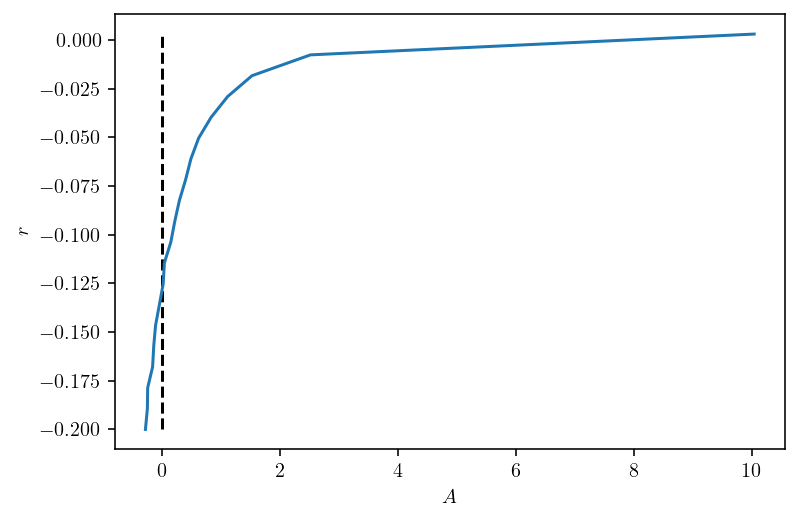

In [69]:
plt.plot(As, rs)
plt.vlines(0, rs[0], rs[-1], color = 'k', linestyles='--')
plt.ylabel(r'$r$')
plt.xlabel(r'$A$')
plt.show()

In [70]:
import scipy.optimize as opt
r_sol = opt.bisect(lambda r: r_to_A(r, parms)[0], -0.2, 0.003)
print('The interest rate that clears the bond market is', r_sol)

The interest rate that clears the bond market is -0.1272523629262214


## Using Quantecon library to solve the model

In general a discrete DP problem can be cast as:

$$ V(s) = \max_{a\in A(s)}[ r(s,a)   + \beta \sum\limits_{s'\in S} V(s') Q(s,a, s')] $$

Hence, in order to apply the Bellman operator, all we need to have is a matrix $R$ and a transition matrix $Q$.


In [76]:
#
class Household:
    def __init__(self,
                gamma = 2.0,
                w=5,        # wages
                β=1.03**(-1/12),       # discount factor
                r=0.001,       # interest rate
                phi = -1.0,
                a_min=-3.0,
                Π = [[0.4, 0.6], [0.6, 0.4]],  # Markov chain
                z_vals=[0.5, 1],             # exogenous states
                a_max=18,
                a_size=200):
        
        # Store values, set up grids over a and z
        self.phi, self.gamma, self.r, self.w, self.β =  phi, gamma, r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
    
        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)
        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()
        
    def build_Q(self):
            populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
            self.R.fill(-np.inf)
            populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w, self.gamma, self.phi)

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w, gamma, phi):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = max(a_vals[new_a_i], phi)
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = c**(1-gamma)/(1-gamma)  # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]

# Create an instance of Household 
am = Household()

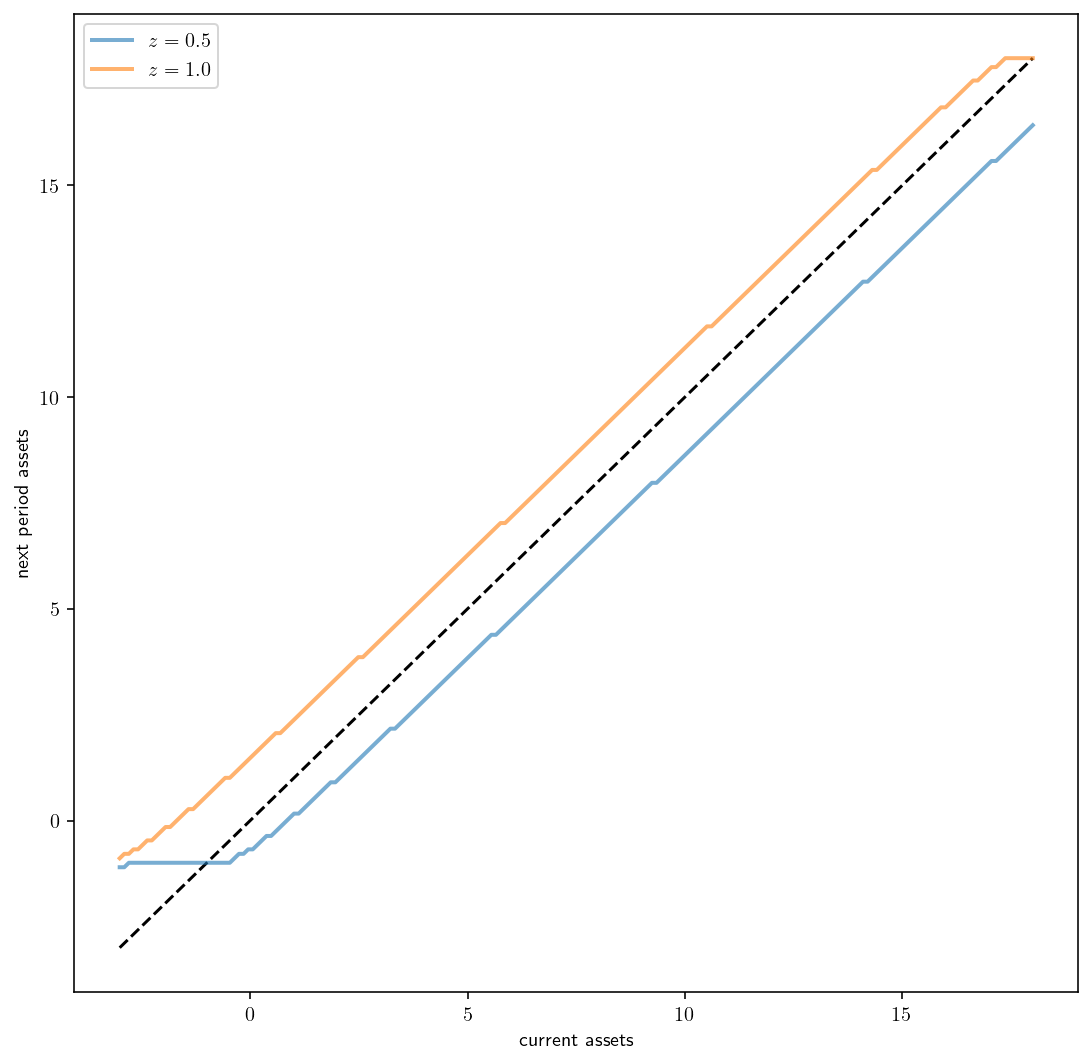

In [77]:
# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Solve using policy function iteration
results = am_ddp.solve(method='value_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = np.empty((z_size, a_size))
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
plt.show()

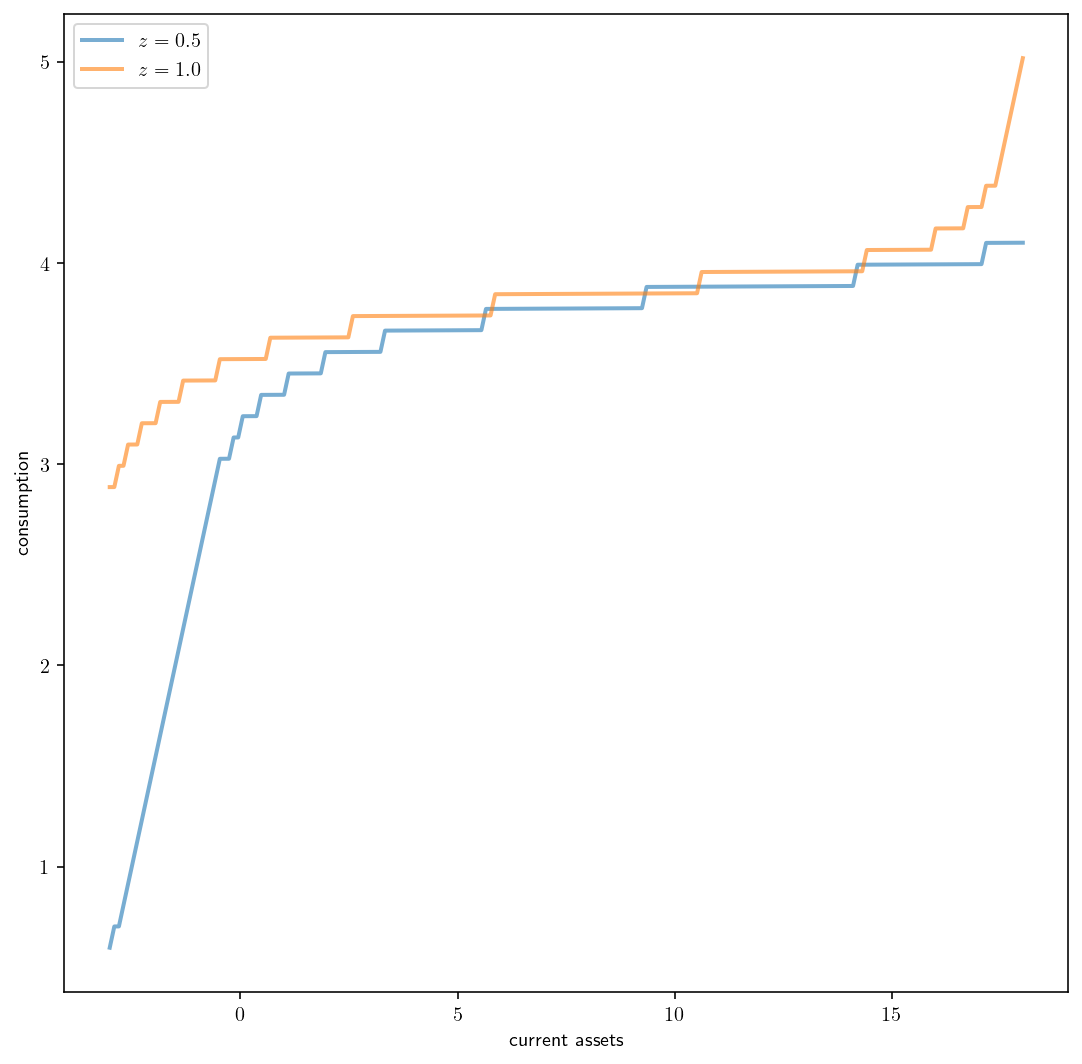

In [78]:
fig, ax = plt.subplots(figsize=(9, 9))
#ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, 5 * z_vals[i] + (1 + am.r) * a_vals - a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('consumption')
ax.legend(loc='upper left')
plt.show()

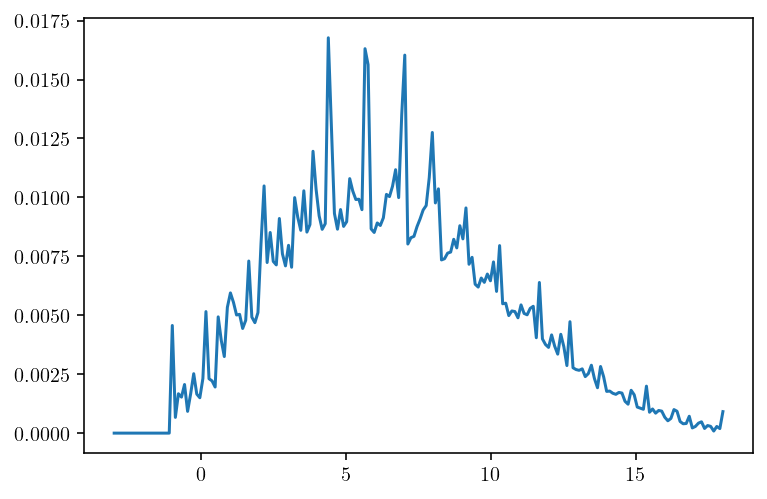

In [79]:
@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
    return a_probs

stationary_probs = results.mc.stationary_distributions[0]
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

plt.plot(a_vals, asset_probs)
plt.show()

In [80]:
A = np.sum(asset_probs * am.a_vals)  
print('Total asset in the economy is', A)

if A>0:
    print('At this interest rate, too much saving!')
else:
    print('At this interest rate, too much borrowing!')

Total asset in the economy is 6.628675744389184
At this interest rate, too much saving!


#### Lets find the interest rate that clears the market

In [81]:
am = Household(r= 0.0001)
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
A = np.sum(asset_probs * am.a_vals)  
print('Total asset in the economy is', A)

if A>0:
    print('At this interest rate, too much saving!')
else:
    print('At this interest rate, too much borrowing!')

Total asset in the economy is 5.5305010938346495
At this interest rate, too much saving!


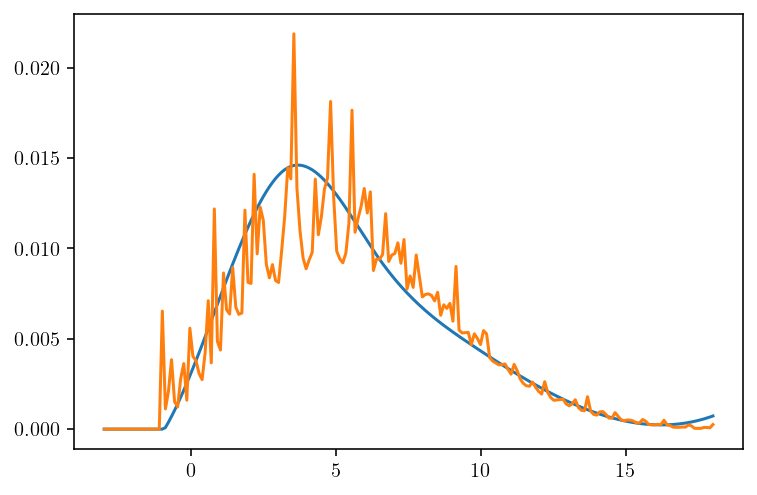

In [82]:
import scipy.interpolate as interp
tck = interp.splrep(a_vals[::30], asset_probs[::30])
dist_spl = interp.splev(a_vals, tck)
dist_spl[dist_spl<=0] = 0
plt.plot(a_vals, dist_spl)
plt.plot(a_vals, asset_probs)
plt.show()

In [83]:
def total_A(r):
    am = Household(r= r)
    am_ddp = DiscreteDP(am.R, am.Q, am.β)
    results = am_ddp.solve(method='policy_iteration')
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    return np.sum(asset_probs * am.a_vals)  

In [84]:
import scipy.optimize as opt
r_sol = opt.bisect(total_A, -0.5, 0.005)
print('The interest rate that clears the bond market is', r_sol)

The interest rate that clears the bond market is -0.10310484896721392


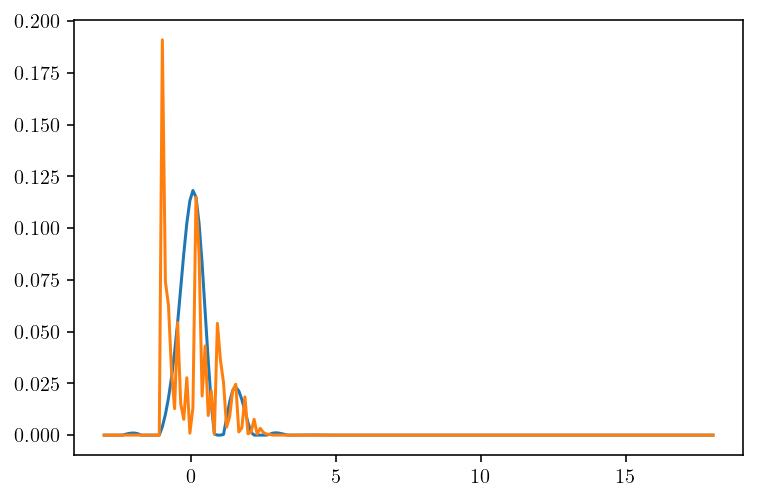

In [85]:
am = Household(r= r_sol)
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

tck = interp.splrep(a_vals[::6], asset_probs[::6])
dist_spl = interp.splev(a_vals, tck)
dist_spl[dist_spl<=0] = 0
plt.plot(a_vals, dist_spl)
plt.plot(a_vals, asset_probs)
plt.show()